In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from sklearn.metrics import f1_score

def show_binary_image(image, title=None):
    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    # Show the image
    plt.imshow(image, cmap=plt.cm.gray)
    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])
    # if a title is provided, show it
    if title is not None:
        plt.title(title)
    plt.show()

image1 = cv2.imread("images/cells/9343 AM.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
image2 = cv2.imread("images/cells/10905 JL.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
image3 = cv2.imread("images/cells/43590 AM.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 

ground_truth1 = cv2.imread("images/cells/9343 AM Edges.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
ground_truth2 = cv2.imread("images/cells/10905 JL Edges.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
ground_truth3 = cv2.imread("images/cells/43590 AM Edges.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 

def preprocess_ground_truth(image: np.ndarray):
    # Create a new array where True is set for elements that are 0 in the original image, and False otherwise
    mask = image == 0
    
    # Convert the boolean mask to integer (1 for True, 0 for False)
    preprocessed_image = mask.astype(int)
    
    return preprocessed_image


ground_truth1 = preprocess_ground_truth(ground_truth1)
ground_truth2 = preprocess_ground_truth(ground_truth2)
ground_truth3 = preprocess_ground_truth(ground_truth3)

# Open the GIF image
gif_image = Image.open('images/shakey.150.gif')

# Let's just take the first frame (index 0) for the static PNG
gif_image.seek(0) 

# Save the current frame as PNG
gif_image.save('images/shakey.png')

# Import PNG
shakey_image = cv2.imread("images/shakey.png", cv2.IMREAD_GRAYSCALE)

def unsharp_masking(image, kernel_size=(3,3), sigma=2, weight_original=5, weight_edges=3, gamma=2):
    gaussian_blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    edges = cv2.subtract(image, gaussian_blurred)
    enhanced_image = cv2.addWeighted(image, weight_original, edges, weight_edges, gamma)
    return enhanced_image


sharp_image1 = unsharp_masking(image1)
sharp_image2 = unsharp_masking(image2)
sharp_image3 = unsharp_masking(image3)


# Function to apply high-pass filter directly to an image array
def apply_high_pass_filter(image):
    # Apply Gaussian blur to create a low-pass filter effect
    blurred_image = cv2.GaussianBlur(image, (49, 49), 8)
    
    # Subtract the blurred (low-pass filtered) image from the original to get high-pass filtered image
    high_pass_filtered_image = cv2.subtract(image, blurred_image)
    
    return high_pass_filtered_image


# Apply the high-pass filter to each image
sharp_filter_image1 = apply_high_pass_filter(sharp_image1)
sharp_filter_image2 = apply_high_pass_filter(sharp_image2)
sharp_filter_image3 = apply_high_pass_filter(sharp_image3)


In [13]:

def calculate_f1_score(ground_truth: np.ndarray, prediction: np.ndarray) -> float:
    """
    Calculate the F1 score between the ground truth and the prediction.

    Parameters:
    - ground_truth (np.ndarray): The ground truth binary image (edges marked with 1).
    - prediction (np.ndarray): The predicted edge binary image.

    Returns:
    - float: The F1 score as a float between 0 and 1, where 1 represents perfect agreement.
    """
    # Flatten arrays to 1D for compatibility with f1_score function
    ground_truth_flat = ground_truth.flatten()
    prediction_flat = prediction.flatten()
    
    # Calculate and return F1 score
    return f1_score(ground_truth_flat, prediction_flat)

scharr_x = np.array([[47, 0, -47], 
                    [162, 0, -162],
                    [47, 0, -47]])

scharr_y = scharr_x.T 

def magnitude_img(G_x: np.ndarray, G_y: np.ndarray) -> np.ndarray:
    """
    Computes the magnitude of the gradient for an image given its horizontal (G_x)
    and vertical (G_y) gradients.

    Parameters:
    - G_x (np.ndarray): The gradient of the image in the x-direction (horizontal).
    - G_y (np.ndarray): The gradient of the image in the y-direction (vertical).

    Returns:
    - np.ndarray: The magnitude of the gradient at each point in the image. The returned
      array is of the same shape as the input arrays and contains the computed gradient
      magnitudes.
    """
    return np.sqrt(G_x**2 + G_y**2) 

def otsus_thresholding(image:np.ndarray, plot: bool = False) -> np.ndarray:
    # Compute histogram with correct bin edges
    histogram_bins = np.arange(257)  # Includes an extra edge to have 256 bins
    histogram, _ = np.histogram(image.ravel(), bins=histogram_bins, range=(0, 256))
    
    # Normalize histogram
    normalized_histogram = histogram / histogram.sum()
    
    # Finding bin centers for calculating cumulative mean correctly
    bin_centers = (histogram_bins[:-1] + histogram_bins[1:]) / 2
    
    # Compute cumulative sum and cumulative mean
    cumulative_sum = np.cumsum(normalized_histogram)
    cumulative_mean = np.cumsum(bin_centers * normalized_histogram)
    
    # Initialize variables for between class variance
    between_class_variance = np.zeros(256)
    total_mean = cumulative_mean[-1]
    
    # Iterate over all possible thresholds to compute between-class variance
    for t in range(1, 256):
        probability_class1 = cumulative_sum[t]
        probability_class2 = 1 - probability_class1
        mean_class1 = cumulative_mean[t] / probability_class1 if probability_class1 > 0 else 0
        mean_class2 = (total_mean - cumulative_mean[t]) / probability_class2 if probability_class2 > 0 else 0
        
        # Calculate between-class variance
        between_class_variance[t] = probability_class1 * probability_class2 * (mean_class1 - mean_class2) ** 2
    
    # Find the threshold that maximizes the between-class variance
    optimal_threshold = np.argmax(between_class_variance)
    
    # Apply the threshold to create a binary image
    thresh = image.copy()
    thresh[image > optimal_threshold] = 255
    thresh[image <= optimal_threshold] = 0
    
    if plot:
        # Plotting
        plt.figure(figsize=(10, 6))
        ax1 = plt.gca()  # Get current axis for the histogram
        ax1.bar(bin_centers, histogram, width=0.5, alpha=0.7)
        ax1.set_ylabel('Frequency')
        ax1.set_xlabel('Intensity Value')
        
        ax2 = ax1.twinx()  # Secondary axis for between-class variance
        ax2.plot(bin_centers, between_class_variance, color='green', linestyle=':', label='Inter-class Variance')
        ax2.set_ylabel('Inter-class Variance')
        
        # Add vertical line for optimal threshold
        ax1.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold}')
        
        plt.xlim(5, 100)
        
        # Adjusting legend
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')
        
        plt.tight_layout()  # Adjust layout to not cut off labelss
        plt.show()

    return thresh


def apply_otsu_scharr(image: np.ndarray, threshold: float = 100) -> np.ndarray: 
    
    image = otsus_thresholding(image)

    G_x = scipy.signal.convolve2d(image, scharr_x, mode="same")
    G_y = scipy.signal.convolve2d(image, scharr_y, mode="same")

    # Calculate the magnitude and direction of the gradient at each pixel
    magnitude_image = magnitude_img(G_x, G_y)  # Magnitude of gradient
    final_edges = magnitude_image > threshold

    return final_edges


otsu_scharr_image1 = apply_otsu_scharr(image1, threshold=1)
otsu_scharr_image2 = apply_otsu_scharr(image2, threshold=1)
otsu_scharr_image3 = apply_otsu_scharr(image3, threshold=1)

ground_truth_images = [ground_truth1, ground_truth2, ground_truth3]


In [ ]:
import numpy as np
import scipy.signal
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

def adaptive_otsus_thresholding(image: np.ndarray, region_size: tuple = (8, 8), plot: bool = False) -> np.ndarray:
    """
    Applies an adaptive Otsu's thresholding method to an image by dividing it into smaller regions.
    
    Parameters:
    - image (np.ndarray): The input image.
    - region_size (tuple): The size of each region (height, width) for local thresholding.
    - plot (bool): Whether to plot the thresholded image.
    
    Returns:
    - np.ndarray: The binarized image after applying adaptive Otsu's thresholding.
    """
    nrows, ncols = image.shape
    rheight, rwidth = region_size
    
    # Prepare an empty image to store the binarized results
    binarized_image = np.zeros_like(image)
    
    # Iterate through the grid of regions
    for row in range(0, nrows, rheight):
        for col in range(0, ncols, rwidth):
            # Define the region
            region = image[row:min(row+rheight, nrows), col:min(col+rwidth, ncols)]
            if region.size == 0:
                continue  # Skip empty regions (shouldn't happen, but just in case)
            
            # Apply Otsu's thresholding to the region
            try:
                local_thresh = threshold_otsu(region)
            except ValueError:
                # Happens if region has all pixels with the same value
                local_thresh = 0
            
            # Binarize the region based on the local threshold
            binarized_region = region > local_thresh
            
            # Store the binarized region back into the binarized image
            binarized_image[row:min(row+rheight, nrows), col:min(col+rwidth, ncols)] = binarized_region
    
    if plot:
        plt.imshow(binarized_image, cmap='gray')
        plt.title("Adaptive Otsu Thresholding Result")
        plt.axis('off')
        plt.show()
    
    return binarized_image


def apply_adaptive_otsu_scharr(image: np.ndarray, region_size: tuple = (8, 8), threshold: float = 100) -> np.ndarray:
    """
    Applies adaptive Otsu's thresholding followed by Scharr operator for edge detection.
    
    Parameters:
    - image (np.ndarray): The input image.
    - region_size (tuple): The size for local thresholding regions.
    - threshold (float): The threshold for determining edges based on gradient magnitude.
    
    Returns:
    - np.ndarray: The edge-detected image.
    """
    # Apply adaptive Otsu's thresholding
    image = adaptive_otsus_thresholding(image, region_size=region_size)
    
    # Apply Scharr filter
    G_x = scipy.signal.convolve2d(image, scharr_x, mode="same")
    G_y = scipy.signal.convolve2d(image, scharr_y, mode="same")
    
    # Calculate the magnitude of the gradient
    magnitude_image = magnitude_img(G_x, G_y)
    
    # Threshold based on the magnitude to detect edges
    final_edges = magnitude_image > threshold
    
    return final_edges


In [17]:
import cv2
import numpy as np
from sklearn.metrics import f1_score
from scipy.signal import convolve2d
from hyperopt import hp, fmin, tpe, Trials

def calculate_f1_score(ground_truth: np.ndarray, prediction: np.ndarray) -> float:
    ground_truth_flat = ground_truth.flatten()
    prediction_flat = prediction.flatten()
    return f1_score(ground_truth_flat, prediction_flat)

def otsus_thresholding(image: np.ndarray, region_size: int) -> np.ndarray:
    """
    Applies adaptive Otsu's thresholding to the image.

    Parameters:
    - image (np.ndarray): The input image.
    - region_size (int): The size of the local region to apply Otsu's method.

    Returns:
    - np.ndarray: The binary image after applying adaptive thresholding.
    """
    img_height, img_width = image.shape
    adaptive_thresh = np.zeros_like(image)
    
    for row in range(0, img_height, region_size):
        for col in range(0, img_width, region_size):
            region = image[row:min(row + region_size, img_height),
                           col:min(col + region_size, img_width)]
            if region.size == 0:
                continue  # Skip empty regions (can happen if region_size doesn't evenly divide image dimensions)
            _, thresh = cv2.threshold(region, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            adaptive_thresh[row:min(row + region_size, img_height),
                            col:min(col + region_size, img_width)] = thresh
    return adaptive_thresh

def apply_otsu_scharr(image: np.ndarray, region_size: int, threshold: float = 100) -> np.ndarray:
    """
    Applies Otsu's thresholding and Scharr operator for edge detection.

    Parameters:
    - image (np.ndarray): The input image.
    - region_size (int): The size of the local region for adaptive Otsu's thresholding.
    - threshold (float): The threshold value for detecting edges based on the gradient magnitude.

    Returns:
    - np.ndarray: The binary image with detected edges.
    """
    scharr_x = np.array([[47, 0, -47], [162, 0, -162], [47, 0, -47]])
    scharr_y = scharr_x.T

    image = otsus_thresholding(image, region_size)
    G_x = convolve2d(image, scharr_x, mode="same")
    G_y = convolve2d(image, scharr_y, mode="same")
    magnitude_image = np.sqrt(G_x**2 + G_y**2)
    final_edges = magnitude_image > threshold
    return final_edges.astype(np.uint8)

def apply_morphological_operation(image: np.ndarray, kernel_size: int, struct_element_shape: int, morph_op: int, region_size: int) -> np.ndarray:
    image_copy = np.copy(image)
    kernel = cv2.getStructuringElement(struct_element_shape, (kernel_size, kernel_size))
    result = cv2.morphologyEx(image_copy, morph_op, kernel)
    otsu_scharr_image = apply_otsu_scharr(result, region_size)
    return otsu_scharr_image

def objective(params):
    kernel_size = int(params['kernel_size'])
    struct_element_shape = int(params['struct_element_shape'])
    morph_op = int(params['morph_op'])
    region_size = int(params['region_size'])
    f1_scores = []
    for image, ground_truth in zip([image1, image2, image3], ground_truth_images):
        predicted_edges = apply_morphological_operation(image, kernel_size, struct_element_shape, morph_op, region_size)
        f1 = calculate_f1_score(ground_truth, predicted_edges)
        f1_scores.append(f1)
    avg_f1 = np.mean(f1_scores)
    return -avg_f1

space = {
    'kernel_size': hp.quniform('kernel_size', 1, 255, 2),
    'struct_element_shape': hp.choice('struct_element_shape', [cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS]),
    'morph_op': hp.choice('morph_op', [cv2.MORPH_GRADIENT, cv2.MORPH_TOPHAT, cv2.MORPH_OPEN, cv2.MORPH_CLOSE]),
    'region_size': hp.quniform('region_size', 8, 1024, 8)  # Example: region sizes from 10 to 100 with step 10
}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=400, trials=trials)

best_kernel_size = int(best['kernel_size'])
best_struct_element_shape = ['MORPH_RECT', 'MORPH_ELLIPSE', 'MORPH_CROSS'][best['struct_element_shape']]
best_morph_op = ['MORPH_GRADIENT', 'MORPH_TOPHAT', 'MORPH_OPEN', 'MORPH_CLOSE'][best['morph_op']]
best_region_size = int(best['region_size'])

print(f"Best kernel size: {best_kernel_size}, Best Structuring Element Shape: {best_struct_element_shape}, Best Morphological Operation: {best_morph_op}, Best Region Size: {best_region_size}")


100%|██████████| 400/400 [08:19<00:00,  1.25s/trial, best loss: -0.9265528300324632]
Best kernel size: 152, Best Structuring Element Shape: MORPH_RECT, Best Morphological Operation: MORPH_TOPHAT, Best Region Size: 736


In [8]:
import cv2
import numpy as np
from hyperopt import hp, fmin, tpe, Trials

def apply_morphological_operation(image: np.ndarray, kernel_size: int, struct_element_shape: int, morph_op: int) -> np.ndarray:
    """
    Applies a morphological operation using a structuring element of the specified size and shape.

    Parameters:
    - image (np.ndarray): The input image.
    - kernel_size (int): The size of the square kernel.
    - struct_element_shape (int): The shape of the structuring element (cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS).
    - morph_op (int): The morphological operation (cv2.MORPH_GRADIENT, cv2.MORPH_TOPHAT, cv2.MORPH_OPEN, cv2.MORPH_CLOSE).

    Returns:
    - np.ndarray: The resulting image after the morphological operation.
    """
    # Create a deep copy of the image to ensure the original is not modified
    image_copy = np.copy(image)

    kernel = cv2.getStructuringElement(struct_element_shape, (kernel_size, kernel_size))
    result = cv2.morphologyEx(image_copy, morph_op, kernel)
    otsu_scharr_image = apply_otsu_scharr(result)  # Assumes this function does not modify its input in-place
    
    return otsu_scharr_image

def objective(params):
    kernel_size = int(params['kernel_size'])
    struct_element_shape = int(params['struct_element_shape'])
    morph_op = int(params['morph_op'])
    f1_scores = []
    for image, ground_truth in zip([image1, image2, image3], ground_truth_images):
        predicted_edges = apply_morphological_operation(image, kernel_size, struct_element_shape, morph_op)
        f1 = calculate_f1_score(ground_truth, predicted_edges)
        f1_scores.append(f1)
    avg_f1 = np.mean(f1_scores)
    return -avg_f1

# Define the search space
space = {
    'kernel_size': hp.quniform('kernel_size', 1, 255, 2),
    'struct_element_shape': hp.choice('struct_element_shape', [cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS]),
    'morph_op': hp.choice('morph_op', [cv2.MORPH_GRADIENT, cv2.MORPH_TOPHAT, cv2.MORPH_OPEN, cv2.MORPH_CLOSE])
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=400, trials=trials)

best_kernel_size = int(best['kernel_size'])
best_struct_element_shape = ['MORPH_RECT', 'MORPH_ELLIPSE', 'MORPH_CROSS'][best['struct_element_shape']]
best_morph_op = ['MORPH_GRADIENT', 'MORPH_TOPHAT', 'MORPH_OPEN', 'MORPH_CLOSE'][best['morph_op']]

print(f"Best kernel size: {best_kernel_size}, Best Structuring Element Shape: {best_struct_element_shape}, Best Morphological Operation: {best_morph_op}")

100%|██████████| 400/400 [07:07<00:00,  1.07s/trial, best loss: -0.4556760856206801]
Best kernel size: 2, Best Structuring Element Shape: MORPH_CROSS, Best Morphological Operation: MORPH_GRADIENT


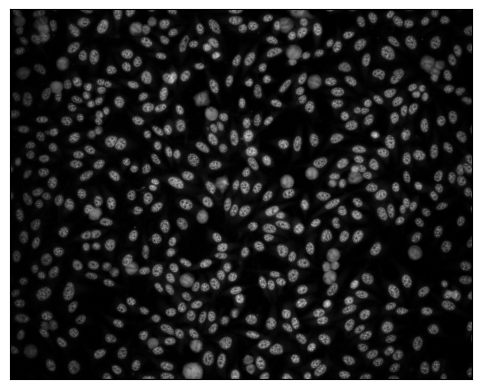

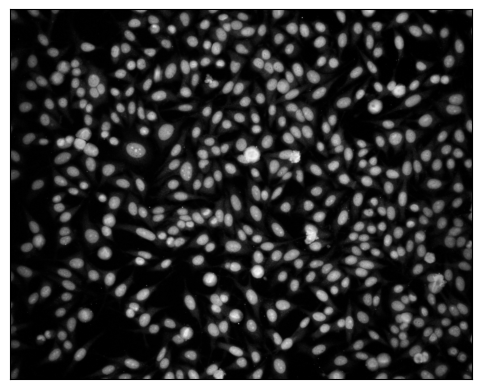

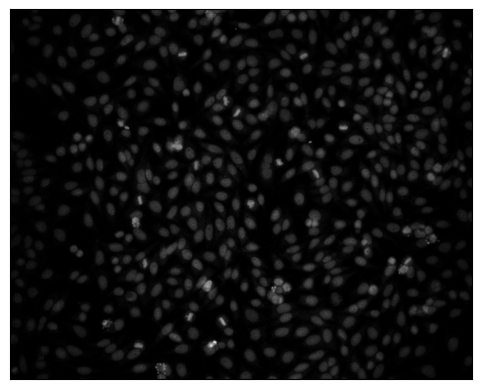

In [24]:
kernel_size = 112
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

# Apply the Top-hat Transform
enhanced_image1 = cv2.morphologyEx(image1, cv2.MORPH_TOPHAT, kernel)
enhanced_image2 = cv2.morphologyEx(image2, cv2.MORPH_TOPHAT, kernel)
enhanced_image3 = cv2.morphologyEx(image3, cv2.MORPH_TOPHAT, kernel)

show_binary_image(enhanced_image1)
show_binary_image(enhanced_image2)
show_binary_image(enhanced_image3)

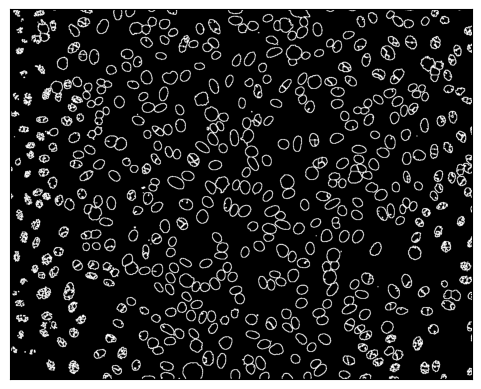

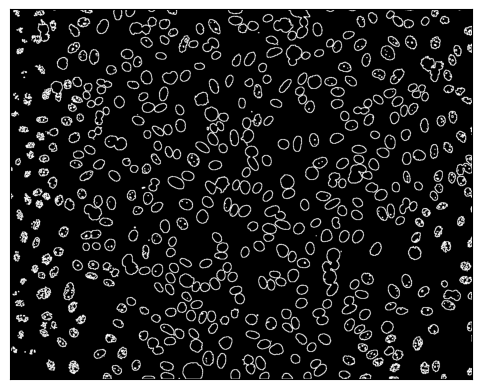

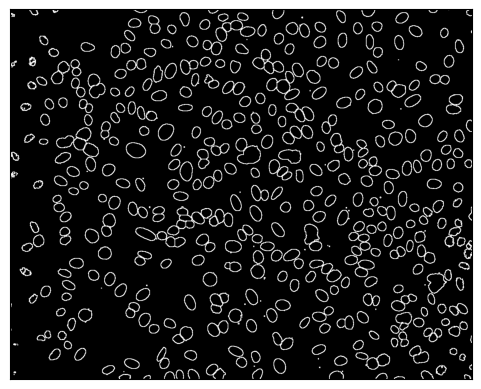

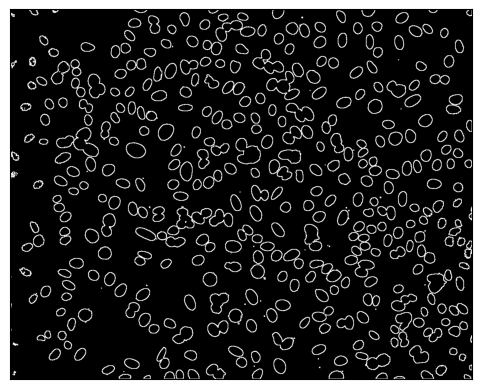

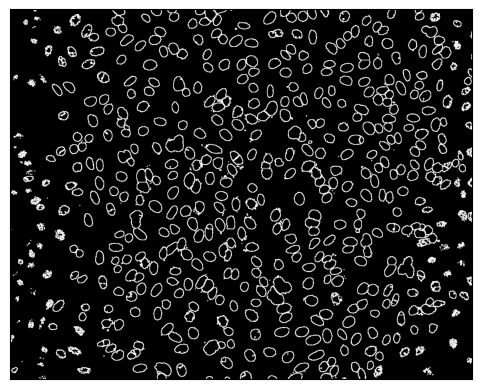

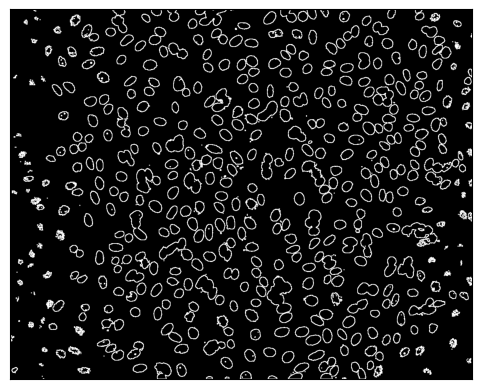

In [25]:
# enhanced_image1 = unsharp_mask(image1, 0.10627836069636026, 1.3408156613254996)
# enhanced_image2 = unsharp_mask(image2, 0.10627836069636026, 1.3408156613254996)
# enhanced_image3 = unsharp_mask(image3, 0.10627836069636026, 1.3408156613254996)


# otsu_scharr_image1 = apply_otsu_scharr(enhanced_image1, threshold=1)
# otsu_scharr_image2 = apply_otsu_scharr(enhanced_image2, threshold=1)
# otsu_scharr_image3 = apply_otsu_scharr(enhanced_image3, threshold=1)




otsu_scharr_image1 = apply_otsu_scharr(enhanced_image1, region_size=736)
otsu_scharr_image2 = apply_otsu_scharr(enhanced_image2, region_size=736)
otsu_scharr_image3 = apply_otsu_scharr(enhanced_image3, region_size=736)


# otsu_scharr_image1 = apply_otsu_scharr(image1, threshold=1)
# otsu_scharr_image2 = apply_otsu_scharr(image2, threshold=1)
# otsu_scharr_image3 = apply_otsu_scharr(image3, threshold=1)

show_binary_image(ground_truth1)
show_binary_image(otsu_scharr_image1)
show_binary_image(ground_truth2)
show_binary_image(otsu_scharr_image2)
show_binary_image(ground_truth3)
show_binary_image(otsu_scharr_image3)

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

def compute_metrics(ground_truth, prediction):
    
    ground_truth = ground_truth.flatten()
    prediction = prediction.flatten()
    
    accuracy = accuracy_score(ground_truth, prediction)
    precision = precision_score(ground_truth, prediction)
    recall = recall_score(ground_truth, prediction)
    F1 = f1_score(ground_truth, prediction)
    MSE = mean_squared_error(ground_truth, prediction)
    
    return accuracy, precision, recall, F1, MSE
# Compute metrics for the first image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth1, otsu_scharr_image1)
print(f"OS IMAGE 1: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the second image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth2, otsu_scharr_image2)
print(f"OS IMAGE 2: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the third image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth3, otsu_scharr_image3)
print(f"OS IMAGE 3: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

OS IMAGE 1: Accuracy: 0.9861885070800781
Precision: 0.9574367633055126
Recall: 0.9034674398936813
F1 Score: 0.9296695014355145
MSE: 0.013811492919921875

OS IMAGE 2: Accuracy: 0.9888954162597656
Precision: 0.9401937888198758
Recall: 0.9172322190335841
F1 Score: 0.9285710780344409
MSE: 0.011104583740234375

OS IMAGE 3: Accuracy: 0.9844978332519532
Precision: 0.9558729517849333
Recall: 0.8828926820551468
F1 Score: 0.9179345301803348
MSE: 0.015502166748046876

